# Clustering Spotify Tracks / Artists using PySpark

#### Import Dependencies

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

#### Create Spark session and import the Dataset

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("SpotifyCSVtoPySpark").getOrCreate()

# Load CSV file into DataFrame
df = spark.read.csv('Hot100.csv', header=True, inferSchema=True)

# Show the DataFrame
df.show()

+--------------------+----------------+--------------------+----+--------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+----------+
|               Track|          Artist|               Album|Year|Duration|Time_Signature|Danceability|Energy|Key|Loudness|Mode|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|Popularity|
+--------------------+----------------+--------------------+----+--------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+----------+
|             7 rings|   Ariana Grande|       thank u, next|2019|  178626|             4|        0.78| 0.321|  1| -10.747|   0|      0.372|       0.562|             0.0|  0.0881|  0.315|139.961|        50|
|          Break Free|   Ariana Grande|My Everything - D...|2014|  214840|             4|       0.686| 0.702|  7|  -5.325|   0|     0.0455|     0.00637|         4.46E-5|   0.20

#### Select which columns will be our features and assemble them in an array

In [3]:
# Select features for clustering
feature_columns = ['Year', 'Duration', 'Time_Signature', 'Danceability', 'Energy', 'Key','Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Popularity']

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)
# Show the first five rows of the DataFrame
df.show(5)

+---------------+-------------+--------------------+----+--------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+----------+--------------------+
|          Track|       Artist|               Album|Year|Duration|Time_Signature|Danceability|Energy|Key|Loudness|Mode|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|Popularity|            features|
+---------------+-------------+--------------------+----+--------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+----------+--------------------+
|        7 rings|Ariana Grande|       thank u, next|2019|  178626|             4|        0.78| 0.321|  1| -10.747|   0|      0.372|       0.562|             0.0|  0.0881|  0.315|139.961|        50|[2019.0,178626.0,...|
|     Break Free|Ariana Grande|My Everything - D...|2014|  214840|             4|       0.686| 0.702|  7|  -5.325|   0|     

#### Create model fitting our df
We will only use column features as is an array of the important variables

In [4]:
# Train a KMeans model
kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(df)


#### Cluster our Tracks

In [5]:
# Make predictions
predictions = model.transform(df)

# Show the result
predictions.select('Track', 'Artist', 'Album', 'prediction').show()

+--------------------+----------------+--------------------+----------+
|               Track|          Artist|               Album|prediction|
+--------------------+----------------+--------------------+----------+
|             7 rings|   Ariana Grande|       thank u, next|         9|
|          Break Free|   Ariana Grande|My Everything - D...|         4|
|     Dangerous Woman|   Ariana Grande|     Dangerous Woman|         0|
|      God is a woman|   Ariana Grande|           Sweetener|         2|
|            Into You|   Ariana Grande|     Dangerous Woman|         0|
|no tears left to cry|   Ariana Grande|           Sweetener|         2|
|       One Last Time|   Ariana Grande|My Everything - D...|         2|
|           positions|   Ariana Grande|           Positions|         9|
|        Side To Side|   Ariana Grande|     Dangerous Woman|         4|
|       thank u, next|   Ariana Grande|       thank u, next|         2|
|            Callaita|       Bad Bunny|    Un Verano Sin Ti|    

#### Graph showing how much tracks are clustered in each cluster by artist

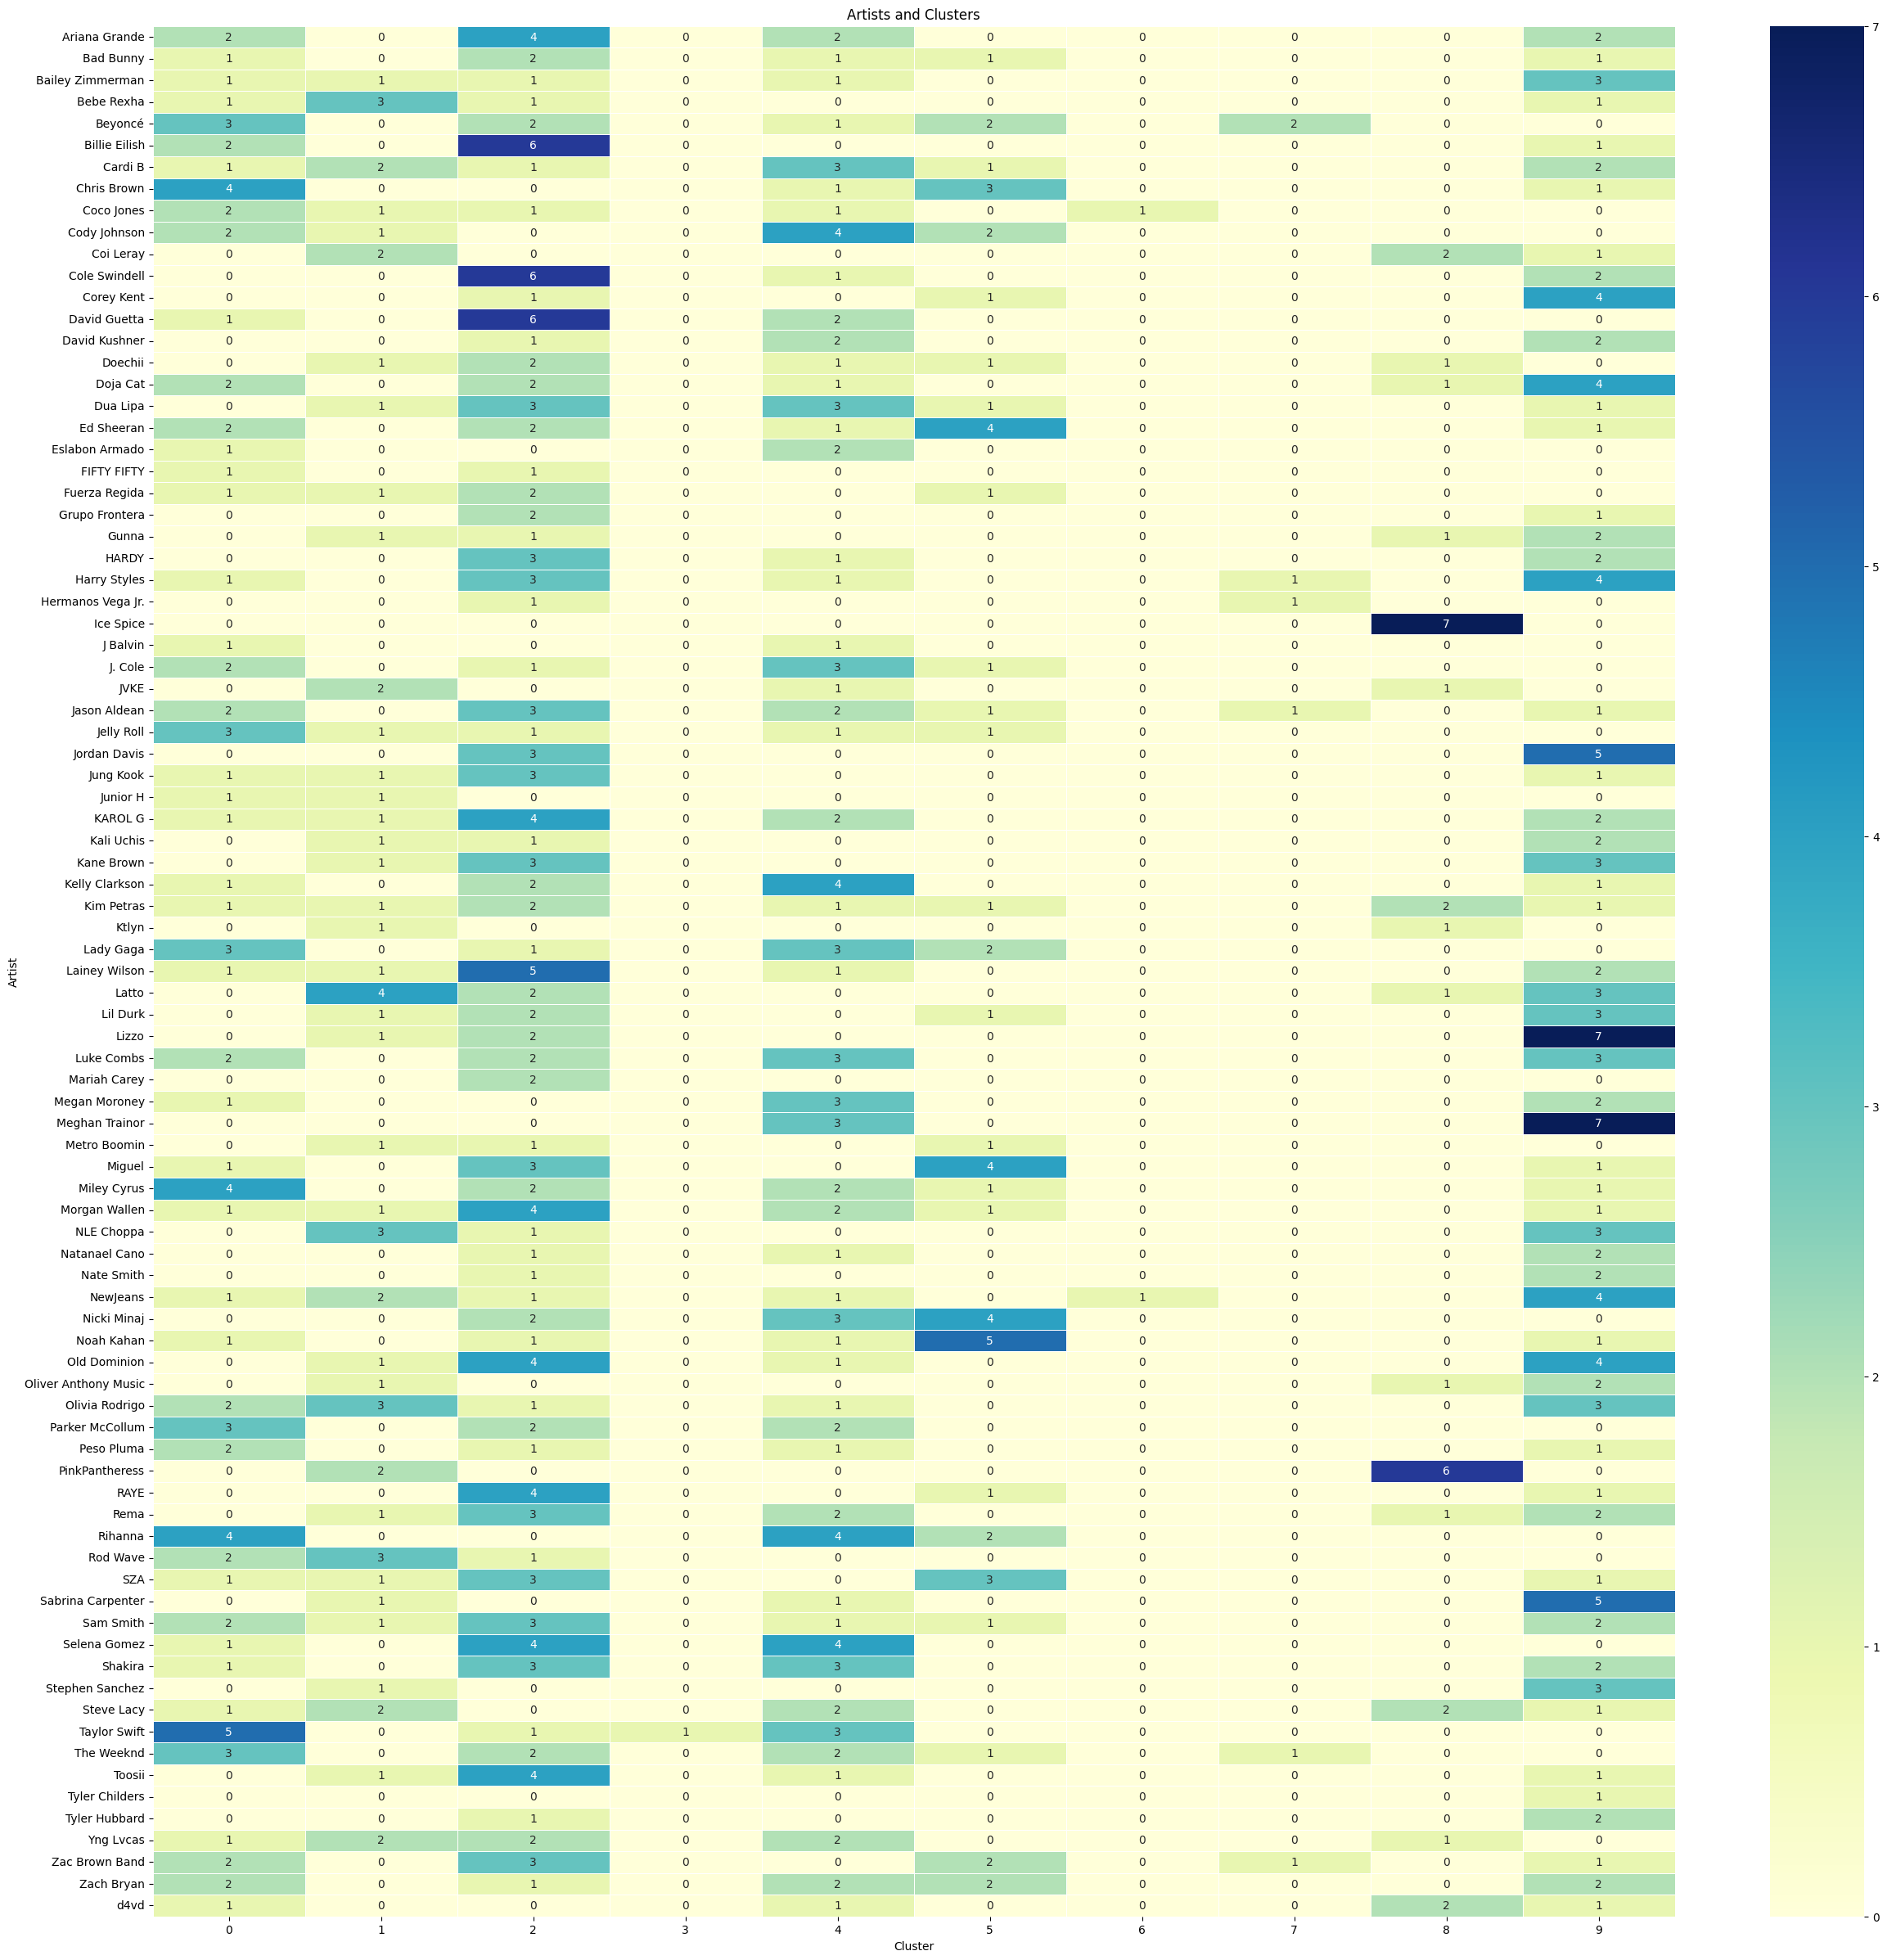

In [6]:

# Convert predictions DataFrame to Pandas DataFrame
pandas_df = predictions.select('Artist', 'prediction').toPandas()

# Create a pivot table for the heatmap
pivot_table = pandas_df.pivot_table(index='Artist', columns='prediction', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu', linecolor='white', linewidths=0.5)
plt.title('Artists and Clusters')
plt.xlabel('Cluster')
plt.ylabel('Artist')
plt.show()

#### Spark session stop
Now that we have all the data we need we should close our spark session

In [7]:
# Stop Spark session
spark.stop()

#### Select Artist

In [8]:
# Find the cluster with the most tracks for each artist
most_tracks_cluster = pivot_table.idxmax(axis=1)
most_tracks_cluster = most_tracks_cluster.reset_index()
most_tracks_cluster.columns = ['Artist', 'Most_Tracks_Cluster']

# Show the result
print(most_tracks_cluster)



              Artist  Most_Tracks_Cluster
0      Ariana Grande                    2
1          Bad Bunny                    2
2   Bailey Zimmerman                    9
3         Bebe Rexha                    1
4            Beyoncé                    0
..               ...                  ...
82     Tyler Hubbard                    9
83         Yng Lvcas                    1
84    Zac Brown Band                    2
85        Zach Bryan                    0
86              d4vd                    8

[87 rows x 2 columns]


#### Which artist would you recommend based on the artist you are listening?

In [9]:
artist='Ariana Grande'

print(f'If you listen to {artist}, you will most likely would like to listen the following artists:')
# Get the cluster number for Ariana Grande
cluster = most_tracks_cluster[most_tracks_cluster['Artist'] == artist]['Most_Tracks_Cluster'].values[0]

# Find artists in the same cluster
similar_artists = most_tracks_cluster[most_tracks_cluster['Most_Tracks_Cluster'] == cluster]['Artist']

# Show the result
print(similar_artists.head())

If you listen to Ariana Grande, you will most likely would like to listen the following artists:
0     Ariana Grande
1         Bad Bunny
5     Billie Eilish
11    Cole Swindell
13     David Guetta
Name: Artist, dtype: object


### Conclusion

In this notebook, we successfully clustered Spotify tracks and artists using PySpark. We followed these steps:

1. **Imported Dependencies**: We imported necessary libraries including PySpark, Pandas, Seaborn, and Matplotlib.
2. **Created Spark Session and Loaded Dataset**: We initialized a Spark session and loaded the dataset from a CSV file.
3. **Selected Features and Assembled Them**: We selected relevant features for clustering and assembled them into a single vector.
4. **Trained KMeans Model**: We trained a KMeans model with the selected features.
5. **Clustered Tracks**: We made predictions using the trained model and clustered the tracks.
6. **Visualized Clusters**: We converted the predictions to a Pandas DataFrame and created a heatmap to visualize the clusters by artist.
7. **Recommended Similar Artists**: Based on the clusters, we recommended similar artists to the one currently being listened to.

By clustering the tracks, we were able to identify patterns and similarities between different artists, which can be useful for making music recommendations. The heatmap provided a clear visualization of how artists are distributed across different clusters, and the recommendation system suggested artists that are similar to the one currently being listened to.